In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes

### Mapping out the LDNe results with Bokeh

In [2]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))

Africa = gpd.read_file("map/Africa.dbf")

Africa.head()

,ID,CODE,COUNTRY,geometry
0,1,ALG,Algeria,"POLYGON ((-5.76362 25.58625, -5.84122 25.63542..."
1,2,ANG,Angola,"POLYGON ((13.36632 -8.32173, 13.36623 -8.32155..."
2,3,ANG,Angola,"POLYGON ((12.80576 -4.80649, 12.80092 -4.81917..."
3,4,ANG,Angola,"POLYGON ((11.76834 -16.79933, 11.76404 -16.799..."
4,5,ANG,Angola,"POLYGON ((12.89840 -5.98802, 12.89370 -5.98675..."


In [3]:
Ne_manifest = pd.read_csv("Ne_manifest.tsv", sep="\t")
Ne_manifest = Ne_manifest[Ne_manifest.counts > 15]
Ne_manifest = Ne_manifest[Ne_manifest.chrom == '2R']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Ne_manifest[['country', 'location', 'year','species_gambiae_coluzzii','chrom',
                         'counts', 'Ne_estimate', 'Jackknife_CI_lower', 'Jackknife_CI_upper']])

,country,location,year,species_gambiae_coluzzii,chrom,counts,Ne_estimate,Jackknife_CI_lower,Jackknife_CI_upper
1,Angola,Luanda,2009,coluzzii,2R,81,342.2,177.8,2064.6
6,Burkina Faso,Bana,2012,coluzzii,2R,42,1510.0,972.2,3344.5
11,Burkina Faso,Bana,2012,gambiae,2R,22,34742.7,5362.1,Infinite
21,Burkina Faso,Pala,2012,gambiae,2R,48,5090.9,2928.9,19232.3
26,Burkina Faso,Souroukoudinga,2012,coluzzii,2R,29,4014.9,2009.9,645921.1
31,Burkina Faso,Souroukoudinga,2012,gambiae,2R,28,Infinite,Infinite,Infinite
36,Burkina Faso,Bana,2014,coluzzii,2R,47,1689.3,1186.4,2918.5
46,Burkina Faso,Pala,2014,gambiae,2R,16,Infinite,Infinite,Infinite
61,Democratic Republic of Congo,Gbadolite,2015,gambiae,2R,76,114.2,64.7,303.2
71,Central African Republic,Bangui,1994,gambiae,2R,53,5508.0,3249.4,17913.3


In [4]:
#Ne_manifest = pd.read_csv("LDNe/unpruned/Ne_manifest.tsv", sep="\t")
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(Ne_manifest[['country', 'location', 'year','species_gambiae_coluzzii','chrom',
#                         'counts', 'Ne_estimate', 'Jackknife_CI_lower', 'Jackknife_CI_upper']])

Filter out any infinite values, and change the Ne columns to float

In [5]:
infinite = Ne_manifest[Ne_manifest.Ne_estimate == 'Infinite']
infinite = infinite[infinite.sample_size > 15]

Ne_manifest = Ne_manifest[Ne_manifest.Ne_estimate != 'Infinite']
Ne_manifest['Ne_estimate'] = Ne_manifest.Ne_estimate.astype(float)
Ne_manifest['markersize'] = np.sqrt(np.sqrt(Ne_manifest['Ne_estimate']))/5
Ne_manifest['markersize'] = Ne_manifest.markersize.clip(lower=1)

infinite['markersize'] = max(Ne_manifest['markersize'])

Ne_manifest = pd.concat([Ne_manifest, infinite])

In [6]:
Ne = gpd.GeoDataFrame(
    Ne_manifest, geometry=gpd.points_from_xy(Ne_manifest.longitude, Ne_manifest.latitude))

Ne.crs = "EPSG:4326"
Africa.crs = "EPSG:4326"

In [7]:
import json
from bokeh.io import show
import bokeh.plotting as bpl
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer# Input GeoJSON source that contains features for plotting

Africa_geosource = GeoJSONDataSource(geojson = Africa.to_json())
Ne_geosource = GeoJSONDataSource(geojson = Ne.to_json())

In [8]:
mapper = linear_cmap(field_name='aim_fraction_colu', palette=Spectral6 ,
                     low=min(Ne['aim_fraction_colu']) ,
                     high=max(Ne['aim_fraction_colu']))

In [9]:
# Create figure object.
p = figure(title = 'LDNe estimates of effective population size in Ag1000g phase 3',
           plot_height = 1200,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
          toolbar_sticky = False)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None # Add patch renderer to figure.

countries = p.patches('xs','ys', source = Africa_geosource,
                   fill_color = None,
                   line_color = 'gray', 
                   line_width = 0.5, 
                   fill_alpha = 1)# Create hover tool

ne_points = p.circle('x','y',source=Ne_geosource, fill_alpha=0.6, radius='markersize', color=mapper)

color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0), title="Aim_fraction")
p.add_layout(color_bar, 'right')

In [10]:
p.add_tools(HoverTool(renderers = [ne_points],
                      tooltips = [('Country','@country'),
                                   ('Location', '@location'),
                                  ('Year', '@year'),
                                  ('Species', '@species_gambiae_coluzzii'),
                                 #  ('AIMs gambiae/coluzzii', '@aim_fraction_colu'),
                                  ('Ne','@Ne_estimate{0.00}'),
                                  ('lower_CI', '@Jackknife_CI_lower'),
                                  ('upper_CI', '@Jackknife_CI_upper'),
                                  ('Sample size', '@sample_size')]))
show(p)

#### Static plot

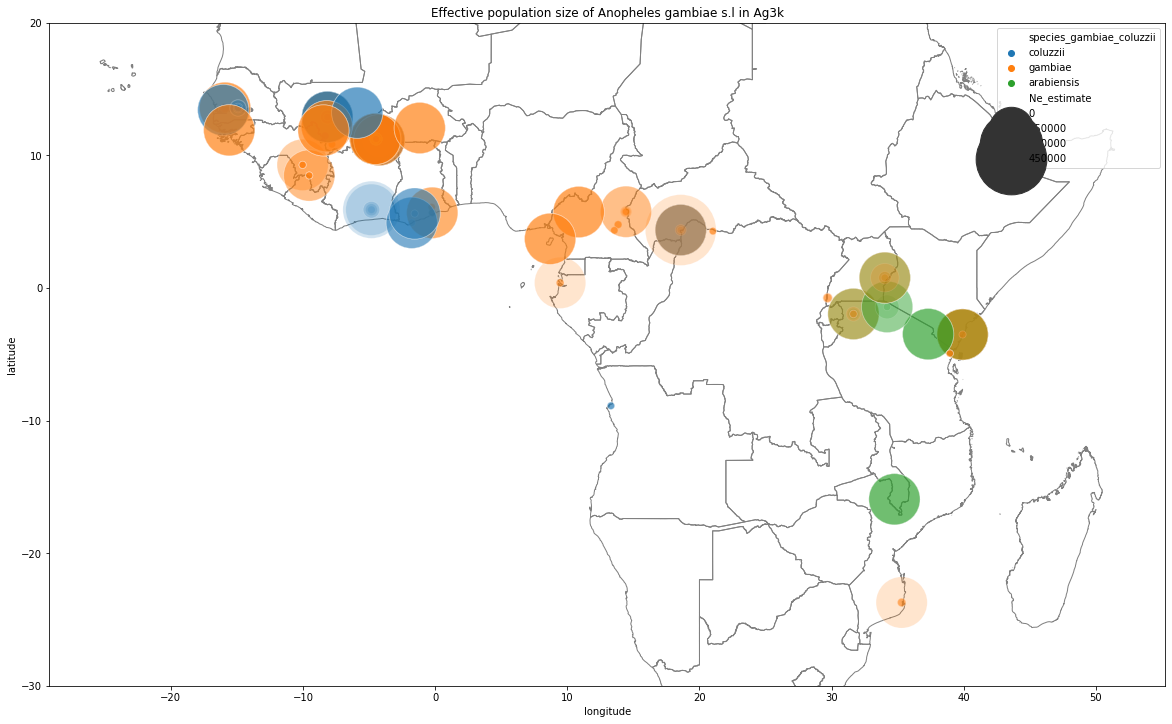

In [27]:
f, ax = plt.subplots(figsize=[20,20])
Africa.plot(ax=ax, color='none', edgecolor='grey')
sns.scatterplot(x=Ne['longitude'], y=Ne['latitude'], data=Ne, 
                size=Ne['Ne_estimate'], sizes=tuple([50,5000]),
                hue=Ne['species_gambiae_coluzzii'], alpha=0.2)
ax.set_ylim(-30, 20) # added/substracted value is to give some margin around total bounds
plt.title("Effective population size of Anopheles gambiae s.l in Ag3k")
plt.savefig("Effective population size of Ag1000g Phase 3 populations")
plt.show()

### Per chromosome boxplots

Lets take all the *Ne* point estimates and plot them as boxplots, grouped by species and chromosome.

In [14]:
Ne_manifest = pd.read_csv("Ne_manifest.tsv", sep="\t")
Ne = Ne_manifest[Ne_manifest.Ne_estimate != 'Infinite']
Ne = Ne[Ne.species_gambiae_coluzzii != 'intermediate']
Ne['Ne_estimate'] = Ne['Ne_estimate'].astype(float)

In [20]:
Ne_manifest = pd.read_csv("Ne_manifest.tsv", sep="\t")

Ne= Ne_manifest.replace("Infinite", 200000)
Ne = Ne[~np.logical_and(Ne.counts < 25, 
                       Ne.Ne_estimate == 20000)]

In [21]:
Ne = Ne[Ne.species_gambiae_coluzzii != 'intermediate']
Ne['Ne_estimate'] = Ne['Ne_estimate'].astype(float)

To label the plot with sample sizes, we need counts per group.

In [22]:
counts = pd.DataFrame(Ne.groupby(['chrom', 'species_gambiae_coluzzii']).size())

counts.reset_index(inplace=True)
counts.columns = ['chrom', 'species_gambiae_coluzzii', 'n_obs']

order = [ 'coluzzii', 'gambiae', 'arabiensis']

counts['species_gambiae_coluzzii'] = pd.Categorical(counts['species_gambiae_coluzzii'], order)
counts = counts.sort_values(['chrom', 'species_gambiae_coluzzii'])

nobs = counts.n_obs
nobs = nobs.append(pd.Series(['0'])).astype(str).tolist() # add a zero for arabiensis X values

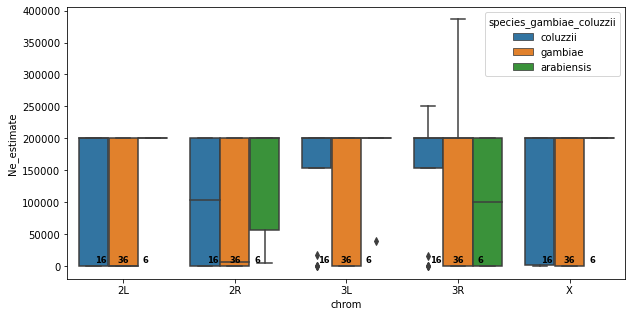

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='chrom', 
            y='Ne_estimate',
            hue='species_gambiae_coluzzii',
            data=Ne, 
            orient="v")

for tick, label in enumerate(ax.get_xticklabels()):
    ax_sex = label.get_text()
    for j, ax_smoker in enumerate(ax.get_legend_handles_labels()[1]):
        x_offset = (j - 1) * 1/5
        num = nobs[((tick*3)+j)]
        ax.text(tick + x_offset, 7000, num,
                horizontalalignment='center', size='small', color='black', weight='semibold')

plt.show()

At first glance, the pattern of Ne estimates seems to mirror the presence of chromosomal inversions in each species, which would make sense, on the basis that LD will be higher within and surrounding the inversions. For example, *An. arabiensis* estimates for 2L are much higher than for *gambiae* and *coluzzii* - *arabiensis* is fixed for 2la whereas 2l+a segregates in *gambiae/coluzzii*. 

I havent formally looked for associations between predicted karyotype % and Ne estimates, however, and there may not be enough data points, particularly for *An. arabiensis*. 

#### Ne from Theta = 4NeMu